### 0. Imports

In [26]:
%load_ext autoreload
%autoreload 2

# Tratamiento de datos
# -----------------------------------------------------------------------
import pandas as pd
import numpy as np

# Visualizaciones
# -----------------------------------------------------------------------
import seaborn as sns
import matplotlib.pyplot as plt

# Vigilar progreso bucles
# -----------------------------------------------------------------------
# from tqdm import tqdm

# Gestionar los warnings
# -----------------------------------------------------------------------
import warnings

# modificar el path
# -----------------------------------------------------------------------
import sys
sys.path.append("..")

# importar funciones de soporte
# -----------------------------------------------------------------------
import src.soporte_eda as se
import src.soporte_preprocesamiento as sp
import src.data_visualization_support as dvs

# evaluar objetos literales
# -----------------------------------------------------------------------
from ast import literal_eval 

# statistics functions
# -----------------------------------------------------------------------
from scipy.stats import pearsonr, spearmanr, pointbiserialr
import association_metrics as am


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# 1. Introduction - Employee Retention - Exploration

After the cleaning phase in `notebooks/1_exploration_cleaning.ipynb`, it is time of exploring the distributions of features and their relationships with respect to the target and other features.

### 1.1 Data import

In [27]:
pd.reset_option("display.max_columns")
employee_attrition = pd.read_pickle("../data/cleaned/employee_attrition_clean.pkl")
employee_attrition.head()

,age,attrition,businesstravel,department,distancefromhome,education,educationfield,gender,joblevel,jobrole,...,totalworkingyears,trainingtimeslastyear,yearsatcompany,yearssincelastpromotion,yearswithcurrmanager,environmentsatisfaction,jobsatisfaction,worklifebalance,jobinvolvement,performancerating
0,51,No,Travel_Rarely,Sales,6,2,Life Sciences,Female,1,Healthcare Representative,...,1.0,6,1,0,0,3.0,4.0,2.0,3,3
1,31,Yes,Travel_Frequently,Research & Development,10,1,Life Sciences,Female,1,Research Scientist,...,6.0,3,5,1,4,3.0,2.0,4.0,2,4
2,32,No,Travel_Frequently,Research & Development,17,4,Other,Male,4,Sales Executive,...,5.0,2,5,0,3,2.0,2.0,1.0,3,3
3,38,No,Non-Travel,Research & Development,2,5,Life Sciences,Male,3,Human Resources,...,13.0,5,8,7,5,4.0,4.0,3.0,2,3
4,32,No,Travel_Rarely,Research & Development,10,1,Medical,Male,1,Sales Executive,...,9.0,2,6,0,4,4.0,1.0,3.0,3,3


# 2. EDA

## 2.1 Questions to answer during analysis

## 2.2 Univariate distributions

In [28]:
visualizador = sp.Visualizador(employee_attrition)

### 2.2.1 Target feature - attrition

Let's first focus on the target feature, attrition, to check the target imabalance.

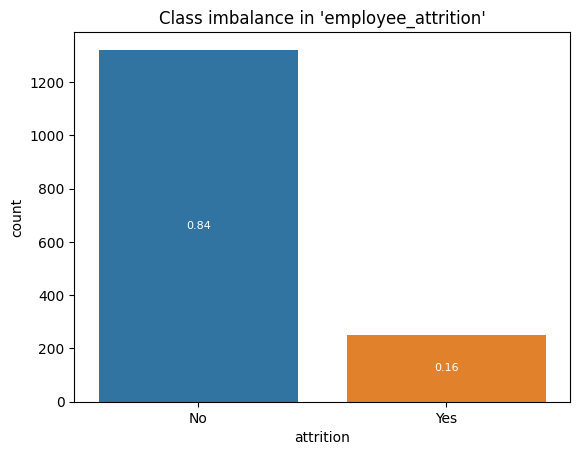

In [29]:
plt.title("Class imbalance in 'employee_attrition'")
ax = sns.countplot(data=employee_attrition, x="attrition", hue="attrition")
dvs.plot_bar_labels(ax, normalize=employee_attrition.shape[0])
plt.show()

There is an important imbalance between clases that will highly impact the metrics to compare across models and the preprocessing steps as well.

### 2.2.2 Numerical features

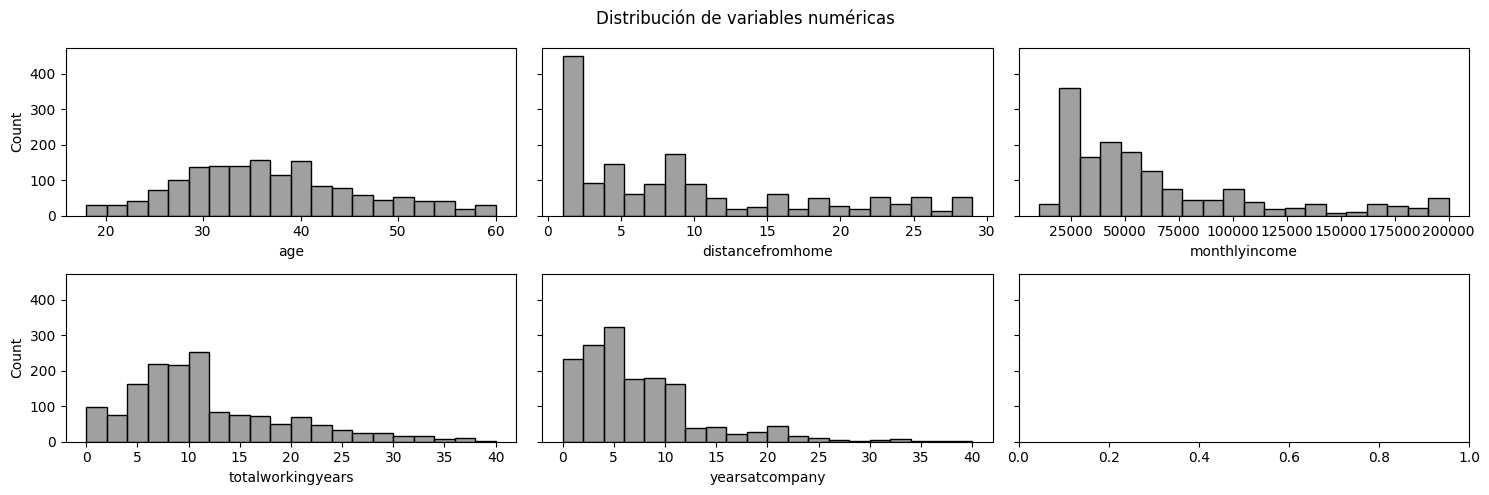

Descriptive statistics of numerical features:


,count,mean,std,min,25%,50%,75%,max
age,1573.0,36.904005,9.105911,18.0,30.0,36.0,43.0,60.0
distancefromhome,1573.0,9.158296,8.124414,1.0,2.0,7.0,14.0,29.0
monthlyincome,1573.0,64979.459631,47121.739301,10090.0,28990.0,49000.0,83800.0,199990.0
totalworkingyears,1564.0,11.245524,7.748763,0.0,6.0,10.0,15.0,40.0
yearsatcompany,1573.0,6.970757,6.068348,0.0,3.0,5.0,9.0,40.0


In [30]:
visualizador.plot_numericas()
plt.show()

print("Descriptive statistics of numerical features:")
employee_attrition.describe().T

Comments about the univariate distributions:
- Age follows a seemingly normal distribution
- distancefromhome follows a distribution that could look exponential, but not yet so. A great number of employees live really nearby, a 25% being 2kms away. There are heavy tails to the right, being the median 7, but the maximum value 29.
- monthlyincome is heavily skewed to the right as well. The median, Q1 and Q3 are to be trusted.
- totalworkingyears. Nonparametric is, again, heavily skewed to the right.
- yearsatcompany. Nonparametric, again, heavily skewed to the right. Could approximate to normal.


### 2.2.3 Categorical features

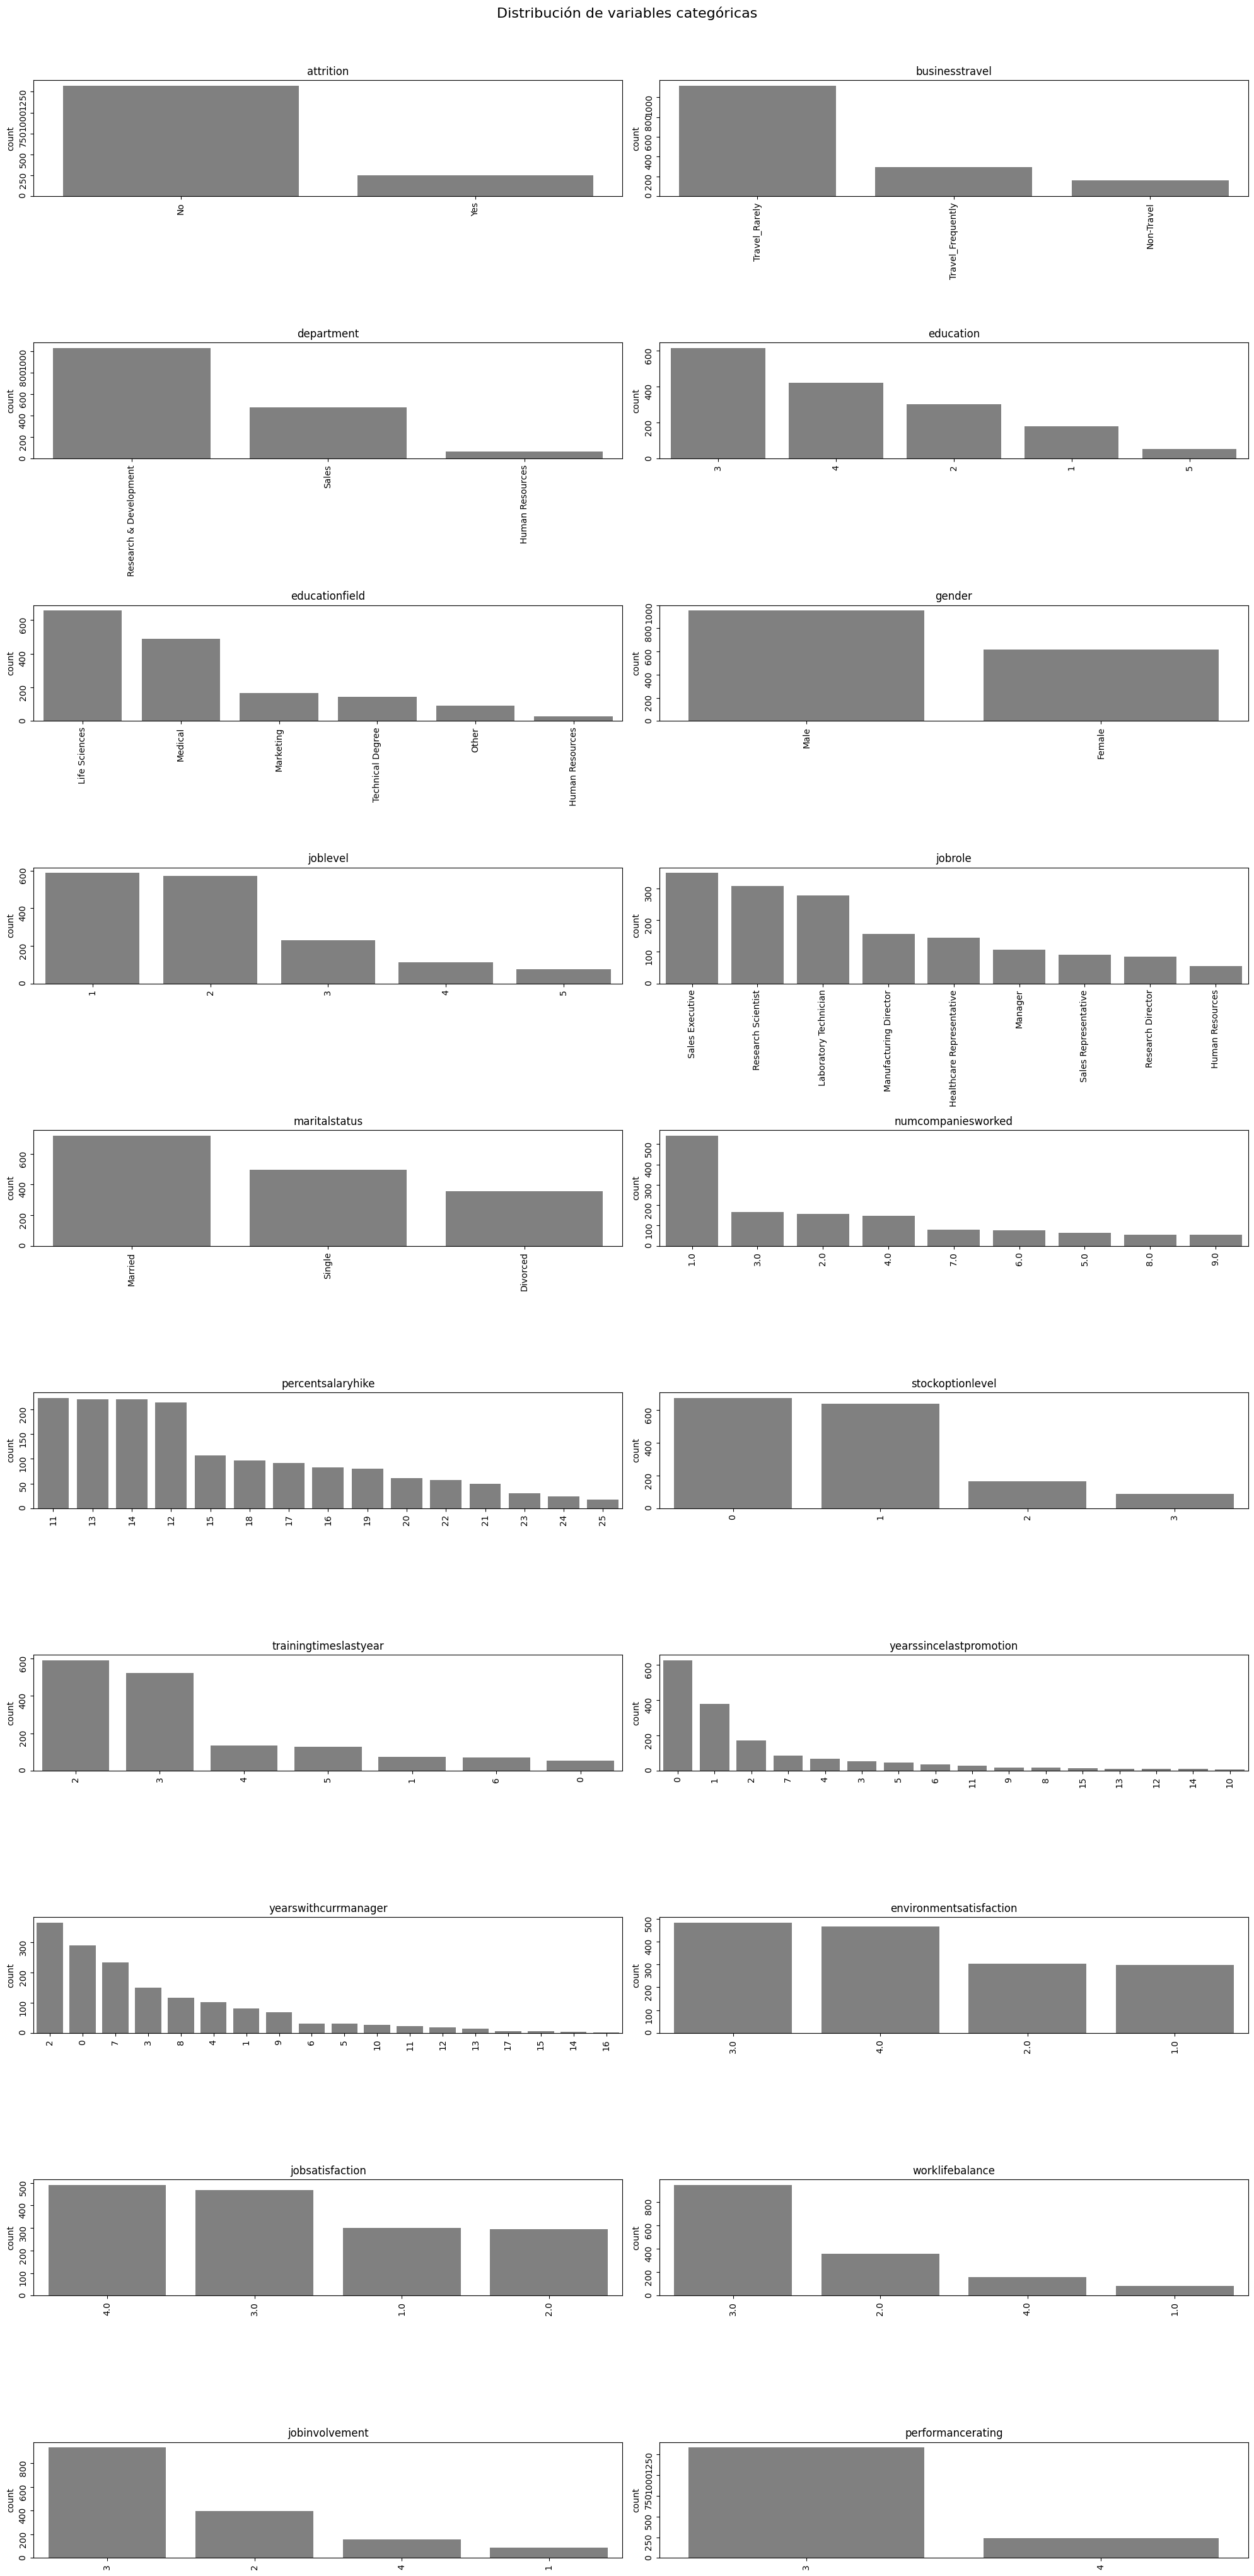

In [31]:
visualizador.plot_categoricas(tamano_grafica=(20, 40))

Most features have enough representation in their less frequent category. However, there are a few that look low. Let's get the least few represented values.



In [32]:
for feature in employee_attrition.select_dtypes("object"):
    least_represented = employee_attrition[feature].value_counts().reset_index().tail()
    if least_represented.iloc[-1,1] < 150:
        display(least_represented)

,department,count
0,Research & Development,1030
1,Sales,477
2,Human Resources,66


,education,count
0,3,615
1,4,422
2,2,303
3,1,181
4,5,52


,educationfield,count
1,Medical,489
2,Marketing,167
3,Technical Degree,144
4,Other,90
5,Human Resources,28


,joblevel,count
0,1,587
1,2,571
2,3,229
3,4,111
4,5,75


,jobrole,count
4,Healthcare Representative,145
5,Manager,107
6,Sales Representative,91
7,Research Director,85
8,Human Resources,54


,numcompaniesworked,count
4,7.0,79
5,6.0,75
6,5.0,65
7,8.0,55
8,9.0,54


,percentsalaryhike,count
10,22,57
11,21,50
12,23,30
13,24,24
14,25,18


,stockoptionlevel,count
0,0,676
1,1,641
2,2,166
3,3,90


,trainingtimeslastyear,count
2,4,133
3,5,129
4,1,75
5,6,70
6,0,55


,yearssincelastpromotion,count
11,15,13
12,13,10
13,12,10
14,14,9
15,10,7


,yearswithcurrmanager,count
13,13,14
14,17,7
15,15,6
16,14,5
17,16,3


,worklifebalance,count
0,3.0,942
1,2.0,357
2,4.0,156
3,1.0,83


,jobinvolvement,count
0,3,933
1,2,395
2,4,155
3,1,90


**Department**

Human Resources category is again the least represented category. It will be worth to decide if it should be grouped with others.

**Education**

Education level 5 has a small sample of 52. However, it will be left as such in case it is later found to be significant.

**Educationfield**

Human Resources category is, as we can see above, underrepresented with just 28 values. Thus, we should join it into Other if we use any model that is not a Logistic Regression or a shallow Decision Tree / Forest.

In [33]:
employee_attrition.replace({"educationfield": {"Human Resources": "Other"}}, inplace=True)

**numcompaniesworked**

Most categories here have a somewhat small representation. They will be left like this for now, expecting to group them in preprocessing if necessary.

**percentsalaryhike**

Last 3 values for percentsalaryhike are too low. As they follow the order, it makes sense to regroup 23, 24 and 25 as 23 or more.

In [34]:
employee_attrition["percentsalaryhike"] = np.where(employee_attrition["percentsalaryhike"] >= 23, "23 or more", employee_attrition["percentsalaryhike"])
employee_attrition["percentsalaryhike"].value_counts()

percentsalaryhike
11            223
13            220
14            220
12            214
15            107
18             96
17             91
16             82
19             80
23 or more     72
20             61
22             57
21             50
Name: count, dtype: int64

**yearssincelastpromotion**

A lot of high values are underrepresented. Thus it is better to group them from a number of years that makes sense and provides a big enough sample:

In [35]:
employee_attrition["yearssincelastpromotion"] = np.where(employee_attrition["yearssincelastpromotion"] >= 8, "8 or more", employee_attrition["yearssincelastpromotion"])
employee_attrition["yearssincelastpromotion"].value_counts()

yearssincelastpromotion
0            625
1            377
2            170
8 or more    112
7             85
4             69
3             53
5             47
6             35
Name: count, dtype: int64

**yearswithcurrmanager**

Similarly,

In [36]:
employee_attrition["yearswithcurrmanager"] = np.where(employee_attrition["yearswithcurrmanager"] >= 10, "10 or more", employee_attrition["yearswithcurrmanager"])
employee_attrition["yearswithcurrmanager"].value_counts()

yearswithcurrmanager
2             364
0             290
7             233
3             149
8             116
10 or more    104
4             103
1              82
9              69
6              32
5              31
Name: count, dtype: int64

## 2.3 Multivariate analysis

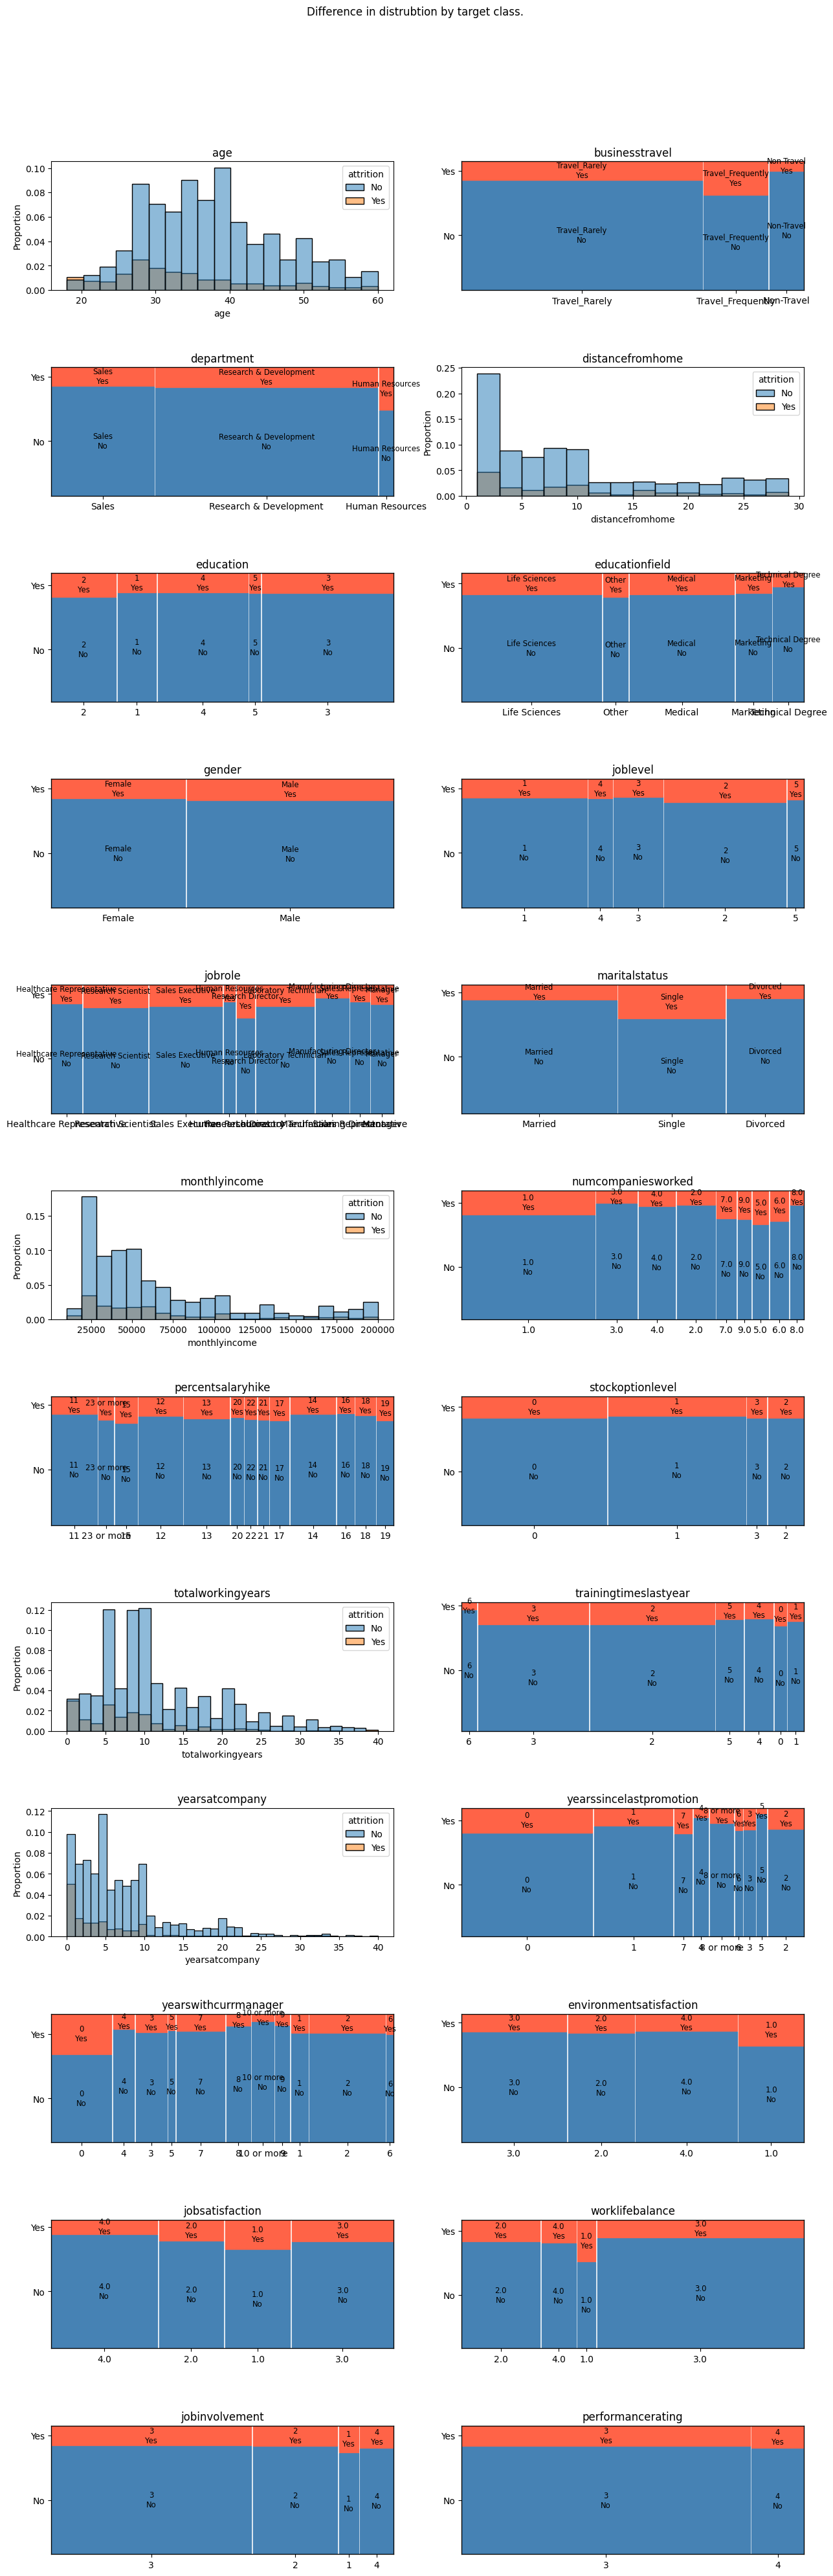

In [37]:
color_mapping = {
    "No": "#4682B4",  # Light Blue (Pastel Blue)
    "Yes": "#FF6347"  # Light Pink (Pastel Red)
}

se.plot_relationships_categorical_target(employee_attrition, "attrition",hue=None, cat_type="mosaic", num_type="hist",mapping=color_mapping)

##### Comments on numerical features

**Age**

From the hued histogram we can extract that attrition is more prominent in workers of young age, where the youngest, around 20 years, show equal number for employees that leave the company as those who do not. This behaviour stabilises around 40 years and then shows a slight increase again for older workers.

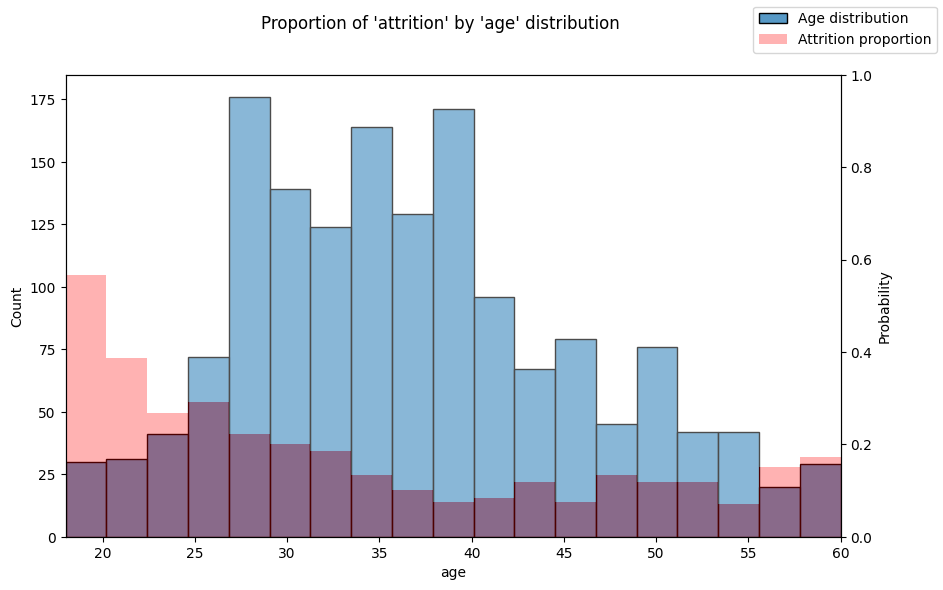

In [38]:
repl_dict = {"Yes": 1, "No": 0}

se.plot_combined_target_distribution(employee_attrition, "attrition", "age", repl_dict=repl_dict)

**distancefromhome**

The above graph shows a similar distribution for both groups. If we plot the distance distribution against the proportion of attrition, like below, we see a ranging trend, where it seems workers living not too far and not too close are the least probable to leave the company.

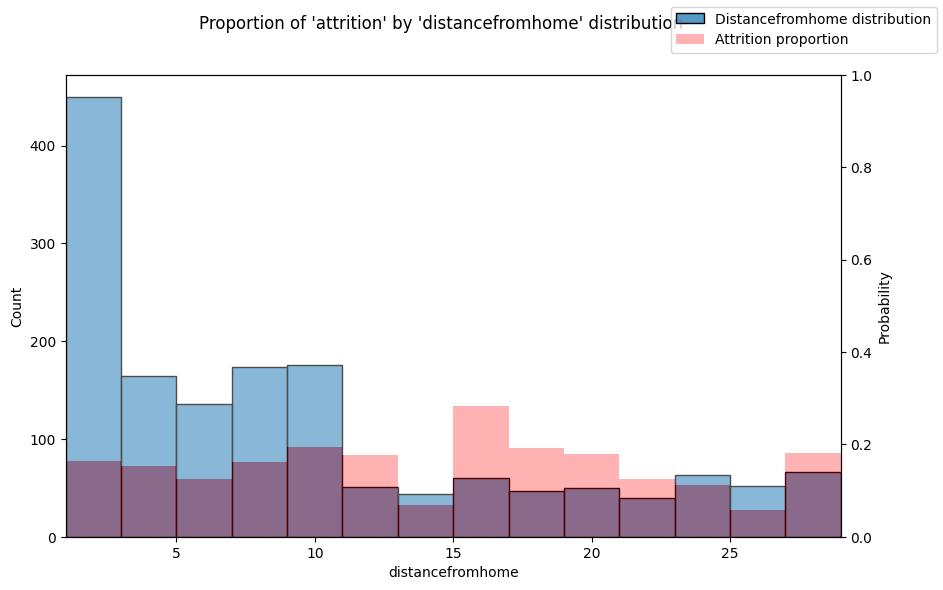

In [39]:
se.plot_combined_target_distribution(employee_attrition, "attrition", "distancefromhome", repl_dict=repl_dict)

**monthlyincome**

In the graph below we see that as income increases, the probability to leave decreases. We also see, however, certain small groups where proportions are very low or very high. This exaggerated probability could be due to the small samples of these groups, although it would be worth analysing them separatedly, 

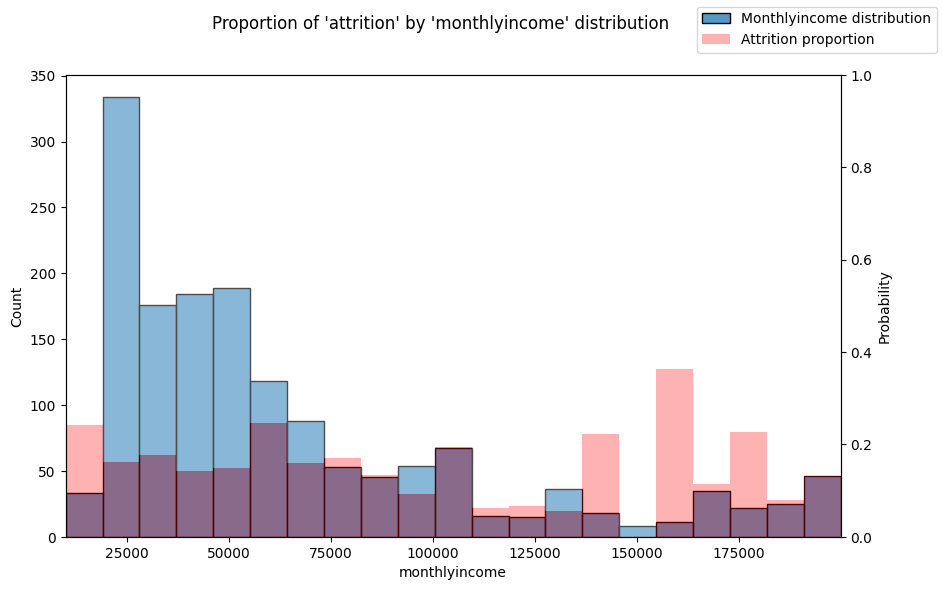

In [40]:
se.plot_combined_target_distribution(employee_attrition, "attrition", "monthlyincome", repl_dict=repl_dict)

**totalworkingyears**

We se a trend where young workers tend to change jobs very quickly, as they are still finding their path and place. As totalworking years increase, the proportion of attrition slowly decreases.

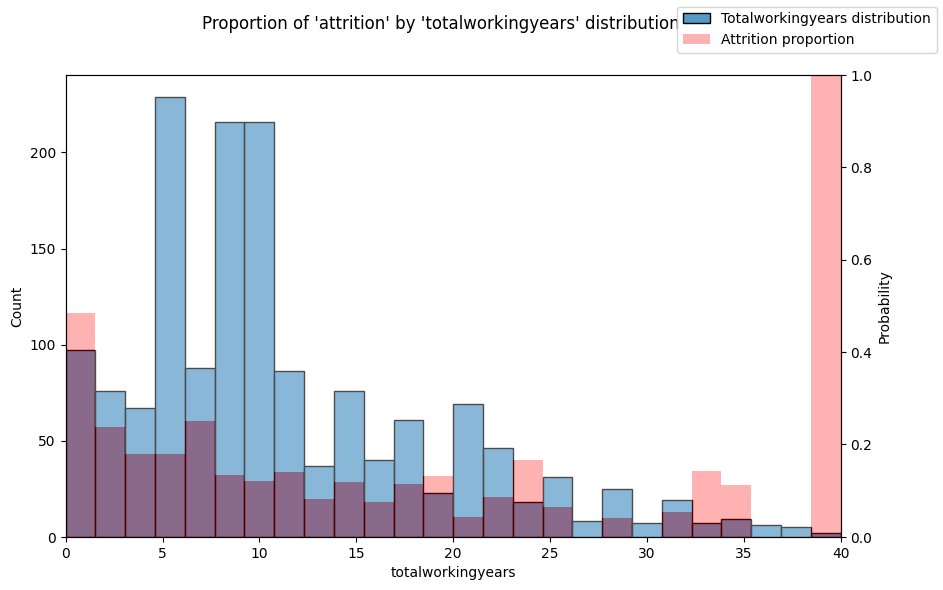

In [41]:
se.plot_combined_target_distribution(employee_attrition, "attrition", "totalworkingyears", repl_dict=repl_dict)

**yearsatcompany**

In a similar fashion, employees who have been in the company for longer, tend to prefer the stability and not leave.

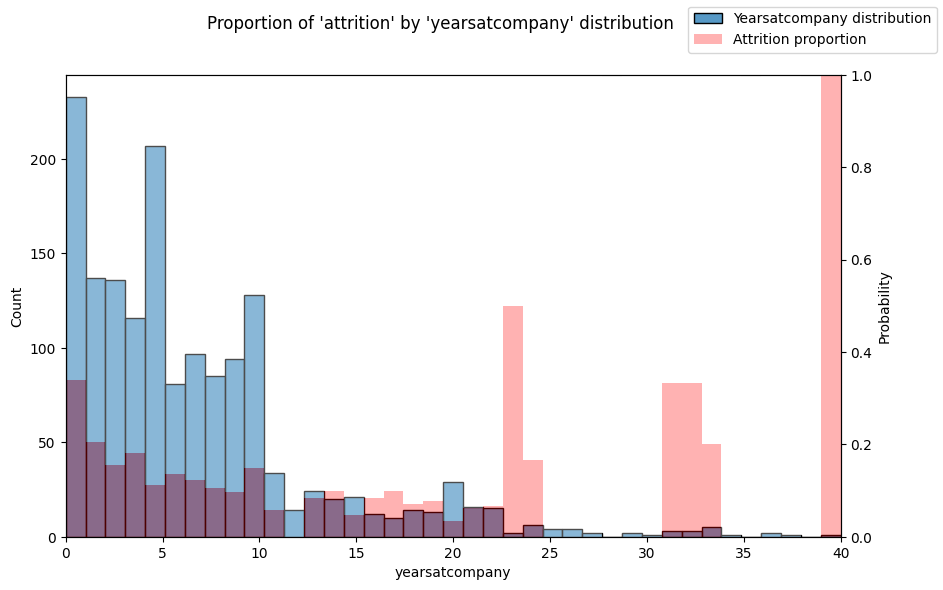

In [42]:
se.plot_combined_target_distribution(employee_attrition, "attrition", "yearsatcompany", repl_dict=repl_dict)

##### Categorical features

**businesstravel**

There is a clear positive correlation with travel frequency and attrition

**department**

Those in the human ressources department show significantly higher attrition than those in Sales or Research & Development.

**education**

There is as a similar level of attrition accross groups. Employees with the highest level of education show the least attrtition, whereas those with low-medium level show the most attrition. This calls for attention due to the non linear trend step between 1 and 2 levels. Those in level 1 might seek more job security or there could be a certain profile in level 2 that is in high market demand. 

**educationfield**

Those in the technical field show the least attrition, while those in non-technical or 'other' show higher levels.

**gender**

Males in general show higher levels of attrition. It will be interesting to contrast this with other subgroups of profiles.

**joblevel**

There is not a clear trend. Level 2 shows the least attrition, while level 5 shows similar levels to level 2, the highest among categories.

**jobrole**

This one is a bit difficult to see, so let's plot it separately.

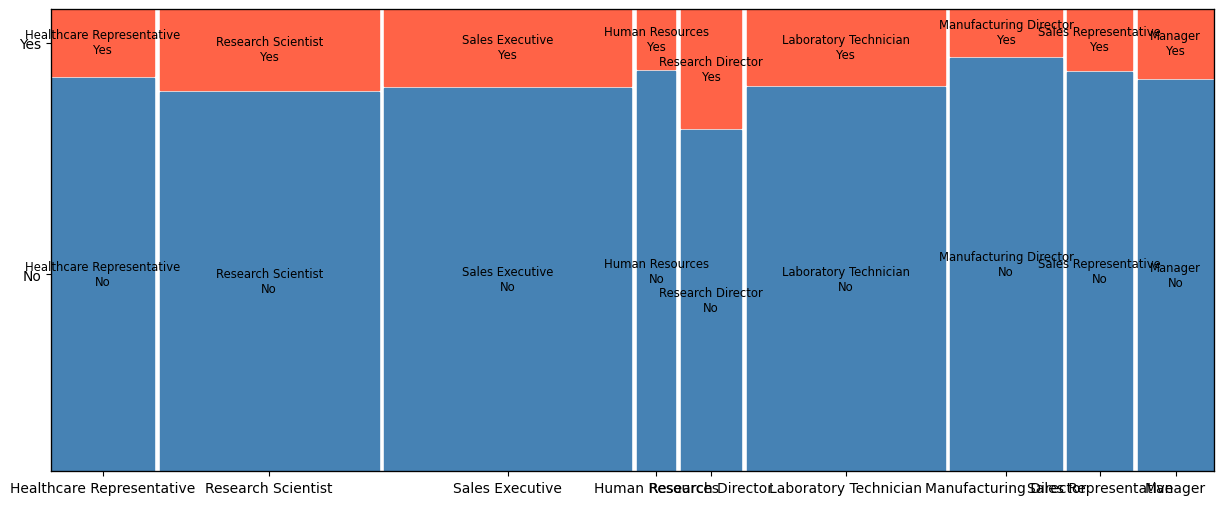

In [46]:
from statsmodels.graphics.mosaicplot import mosaic

fig, ax = plt.subplots(figsize=(15, 6)) # needed so the mosaic adjusts to the figsize

mosaic(employee_attrition, ["jobrole","attrition"], properties=se.custom_properties(color_mapping), ax=ax)
plt.show()

It is very curious to see that Human Resources jobrole has low attrition, whereas we saw that Human Resources department displays the highest level of attrition. Research Directors show the highest level of attrition in this case as well as the scientists, that do not leave the company as much, but draws attention to the fact that there might be some kind of organisational problem with this team. Other grops display similar levels, except for HR as we said, and the manufacturing directors that show the lowest level.

**maritalstatus**

Divorced seek stability the most, whilst single people are more open to adventures.

**numcompanies worked**

There is some kind of trend where people that have worked for not so many companies tend to stay more than those who have worked for a lot. The exception lies in those who have worked for 1, which might mostly hold people still discovering their career paths and 8, which might hold this group of role changing people in a moment the start to settle down.

**percentsalaryhike**

Very curiously, low percentages show less percentage of atttrition. There might a variable interacting here that's causing this pattern

**stockoptionlevel**

Does not look like a particular main effect feature.

**trainingtimeslastyear**

In general, the less trainings the more attrition.

**yearssincelastpromotion**

Unclear trend. There are groups with markedly less or more attrition, but they are smaller. They might be displaying the effect of some other category. For example in 0 category, there might be the newcomers whom are prone to leaving.

**yearswithcurrentmanager**

The clearest pattern is that, people with 0 years have no bond with their manager. Then, as time goes by, employees show less sign of wanting to change managers, a fact that solidifies after 8 years.

**environmentsatisfaction**

A low environment satisfaction is a clear indication that an employee might resign.

**jobsatisfaction**

Less dicotomical than the former, jobsatisfaction progressively escalates in attrition levels as it lowers.

**worklifebalance**

Low worklife balance screams attrition. 

**jobinvolvement**

Similarly, people whose bosses identify as low involved, display higher rates of attrition.

**performancerating**

Very interestingly, a high performance rating is correlated with a high rate of attritition. 

This fact could be explained by the fact that, if an employee is not satisfied with their position and they are making efforts, their dissatisfaction increases. Or, alternatively, if they are top-performing employees, they probably receive other offers.

# 3. Export to preprocessing exploration

This analysis is enough for a first iteration to try version of both a very simple model with the few most important characteristics and a brute model with all columns. This project continues in `notebooks/3_preprocessing.ipynb`.

In [21]:
employee_attrition.to_pickle("../data/explored/employee_attrition_explored.pkl")